<a href="https://colab.research.google.com/github/Ananya-1233/BERT-Classification/blob/main/Covid_Text_Classification_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile

data_zip = zipfile.ZipFile('/content/covid-19-nlp-text-classification.zip')
data_zip.extractall()             
data_zip.close()

Define the training and testing directives.

Get the BERT models from tensorflow hub

In [3]:
train_dir = '/content/Corona_NLP_train.csv'
test_dir = '/content/Corona_NLP_test.csv'

BERT_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'   #BERT encoder model
BERT_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'              #Preprocess data into the form expected by BERT

Define the various classnames and intialize batch size, number of epochs and learning rate for the BERT encoder model.

In [4]:
classnames = ['Extremely negative' , 'Negative' , 'Positive' , 'Extremely Positive' , 'Neutral']

BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 1e-04

In [6]:
# -- Import Libraries -- 
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from official.nlp import optimization
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers, losses, preprocessing

tf.get_logger().setLevel('ERROR')

In [7]:
#Read the training and testing csv files

train_data = pd.read_csv(train_dir , encoding = 'L1')
test_data = pd.read_csv(test_dir , encoding = 'L1')

train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Plot a graph that visualizes the data distribution based on the different classes

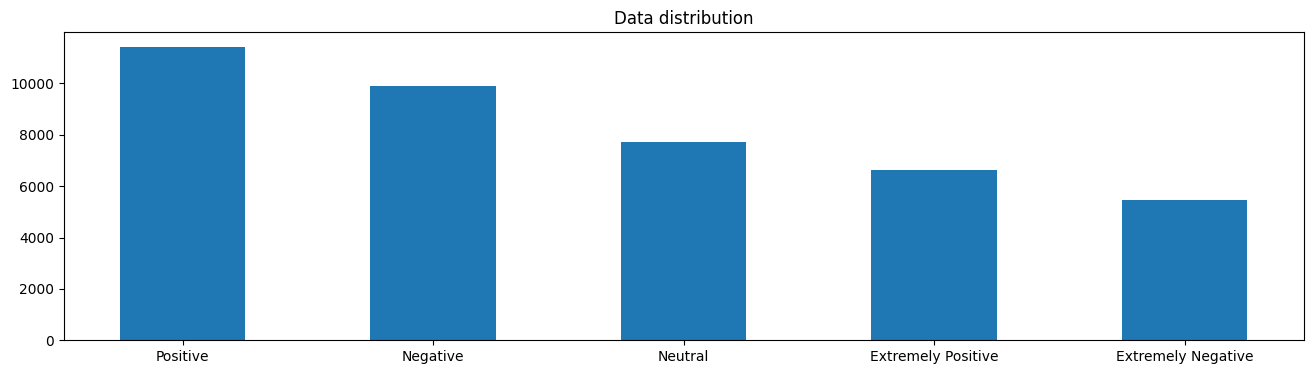

In [8]:
fig = plt.figure(figsize = (16 , 4))
x = train_data.Sentiment.value_counts()

plt.bar(x = x.index,
        height = x.values,
        width = 0.5)

plt.title('Data distribution')

plt.show()

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Use the NLTK module of NLP and lambda function to remove stopwords.


In [10]:
sw_nltk = stopwords.words('english')
remove_stopwords = lambda text : " ".join([word for word in str(text).split() if word.lower() not in sw_nltk])
train_data['OriginalTweet'] = train_data['OriginalTweet'].apply(remove_stopwords)

In [11]:
#Print a sample text with its respective class.

print(f'Text:{train_data.OriginalTweet[3]}\n')
print(f'Target: {train_data.Sentiment[3]}')

Text:food stock one empty... PLEASE, panic, ENOUGH FOOD EVERYONE take need. Stay calm, stay safe. #COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j

Target: Positive


In [12]:
#Split the training dataset in training and validation dataset

from sklearn.model_selection import train_test_split

train_X , val_X , train_y , val_y = train_test_split(train_data['OriginalTweet'],
                                                     train_data['Sentiment'],
                                                     test_size = 0.3)

test_X , test_y = test_data['OriginalTweet'],test_data['Sentiment']

Using sklearn's LabelEncoder, get encoded labels for the different classes(One Hot Encoded labels)

In [13]:
label_encoder = LabelEncoder()

vec = label_encoder.fit_transform(train_y)
train_y = tf.keras.utils.to_categorical(vec)

vec = label_encoder.fit_transform(val_y)
val_y = tf.keras.utils.to_categorical(vec)

vec = label_encoder.fit_transform(test_y)
test_y = tf.keras.utils.to_categorical(vec)

In [14]:
train_y

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [15]:
#Generate a BERT tensorflow model

def bert_model():

  text_input = tf.keras.layers.Input(shape = (),
                                     dtype = tf.string,
                                     name = 'text_Input')
  
  preprocessing_layer = hub.KerasLayer(BERT_preprocess,
                                       name = 'preprocessing')
  
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(BERT_encoder,
                           trainable = True,
                           name = 'BERT_encoder')
  
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(5,
                              activation = 'softmax',
                              name = 'classifier')(net)
  model = tf.keras.Model(text_input , net)

  return model

#Obtain an instance of the model

model = bert_model()

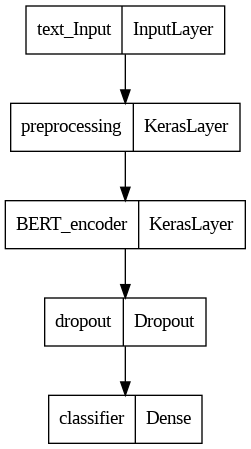

In [16]:
#Plot the anatomy of the model 

tf.keras.utils.plot_model(model)

In [17]:
# -- Optimizer -- 
# will use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). 
train_data_size = len(train_X)
steps_per_epoch = int(train_data_size/BATCH_SIZE)
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps/BATCH_SIZE)

optimizer = optimization.create_optimizer(init_lr=LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# -- compile the model --
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_X,
                    train_y,
                    validation_data=(val_X, val_y),
                    epochs=1,
                    validation_steps=1,
                    verbose=0,
                    batch_size=BATCH_SIZE)

In [21]:
# -- Testing --
loss, accuracy = model.evaluate(test_X , test_y)
print("Test loss: ", loss, ", Test Accuracy: ", 100*accuracy, "%")

119/119 [==============================] - 16s 131ms/step - loss: 1.1134 - accuracy: 0.7283
Test loss:  1.113360047340393 , Test Accuracy:  72.82780408859253 %


In [22]:
# -- Save the Model -- 
model.save('classifier_model')

901/901 [==============================] - 96s 106ms/step


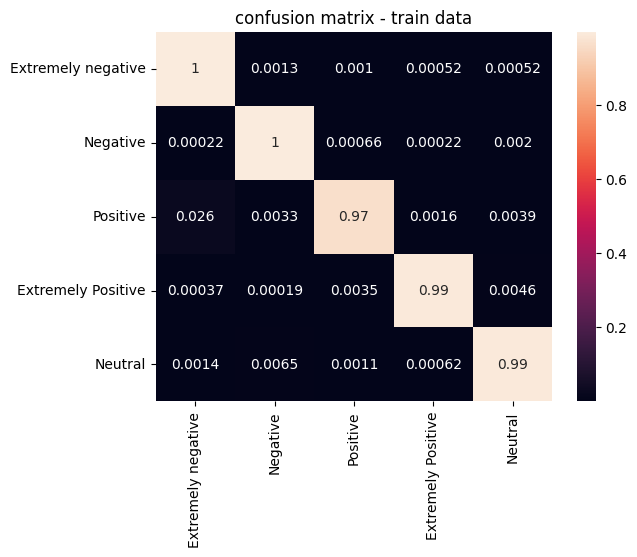

In [23]:
plt.title('confusion matrix - train data')
plt.xlabel("Predicted")
plt.ylabel("True")

preds = model.predict(train_X)

# Convert the one-hot labels into scalar values
train_labels = tf.argmax(train_y, axis = 1)
preds_labels = tf.argmax(preds, axis = 1)

conf_matrix = tf.math.confusion_matrix(train_labels,
                                       preds_labels,
                                       5,
                                       dtype=tf.dtypes.float32)

# Normalize the confusion matrix so that each row sums to 1.
cm_train = conf_matrix/conf_matrix.numpy().sum(axis=1)[:, tf.newaxis]

sns.heatmap(data=cm_train,
            annot=True,
            xticklabels=classnames,
            yticklabels=classnames)

plt.show()